In [116]:
import pyabc
import scipy
import numpy as np
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix2,plot_kde_matrix_for_paper
from datetime import datetime
import pandas as pd
from arviz import hdi
from pyabc.visualization import plot_kde_matrix_highlevel, plot_kde_matrix
import numpy as np
import matplotlib.pyplot as plt

path = '/Users/adsurbum/sim-data/single-model-abc/new4'
output_path = '../../figures'

f = '2021-12-29-an200-k1'

### You can jump [loading section](#loading) if you want only to plot figure and the data is already persisted

In [117]:
import sys  
sys.path.insert(0, '../models')
from singleLocusModel import SingleLocusModel
model = SingleLocusModel(k=1, stopon=3000, fixation=0.95)
N = 6*10**6

In [118]:
history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, f))
samples, weights = history.get_distribution(m=0, t=None)
columns = list(samples.columns)
kde = scipy.stats.gaussian_kde(samples.T.values.tolist(), weights=weights)
size = 50000
samples = kde.resample(size).T
samples = pd.DataFrame(data=samples,columns=['mutation rate', 'trisomy rate', '2n+1 fitness', '2n+1* fitness', '2n* fitness'])
samples = samples.iloc[:,:]

In [119]:
np.all(n>0)

TypeError: '>' not supported between instances of 'list' and 'int'

In [120]:
%%time
reps = 10000
# params = [[p[0],p[1],p[1],*p[2:]] for p in samples.sample(10).values]
model = SingleLocusModel(k=1, stopon=3000, fixation=0.999)
ps = []
grades = []
params = []
i=0
while i<20:
    n = samples.sample(1).values[0]
    if not np.all(n>0):
        continue
    n = [n[0],n[1],n[1],*n[2:]]

    times, p = model.run_simulations(N, *n, repetitions=reps, seed=111) #TODO 10,000
    grade = model.grade_function((times,p))
    if grade<-0.0002:
        i+=1
        grades.append(grade)
        ps.append(p)
        params.append(n)
        print(grade)

-0.28667367055799986
-0.6555038420356609
-0.6009463251852317
-0.7228574115299328
-0.641023541896445
-0.8691048272659998
-0.2564115880505088
-0.6910366732396638
-0.49031025297750375
-0.6819551554803167
-0.8029961535152225
-0.204183339619875
-0.14958877497262368
-0.7407611281840002
-0.02731564950257581
-0.8680194851118048
-0.7440903718080001
-0.24190395106625562
-0.02731564843331047
-0.6989579373893088
CPU times: user 3h 49min 43s, sys: 3min 57s, total: 3h 53min 40s
Wall time: 4h 34min 31s


In [115]:
# takes too much disk space
# np.savez_compressed('./outputs/dynamics',params=params, grades=grades, ps=ps)
# loaded = np.load('./outputs/dynamics.npz',allow_pickle=True)
# params, grades, ps = loaded['params'], loaded['grades'], loaded['ps']

In [124]:
%%time
import numpy as np
progresses_median = []
progresses_mean = []
for p in ps[:]:
    nparr = np.array(p)
    progresses_median.append(
    [[np.median(a) for a in nparr[:,0][:]],
    [np.median(a) for a in nparr[:,1][:]],
    [np.median(a) for a in nparr[:,2][:]],
    [np.median(a) for a in nparr[:,3][:]]])
    
    progresses_mean.append(
    [[a.mean() for a in nparr[:,0][:]],
    [a.mean() for a in nparr[:,1][:]],
    [a.mean() for a in nparr[:,2][:]],
    [a.mean() for a in nparr[:,3][:]]])

CPU times: user 1min 18s, sys: 1min 9s, total: 2min 27s
Wall time: 4min 50s


<a id='loading'></a>

# Loading persisted
## uncomment the next cell if needed

In [125]:
np.savez('./outputs/dynamics-summary',progresses_median=progresses_median, progresses_mean=progresses_mean)

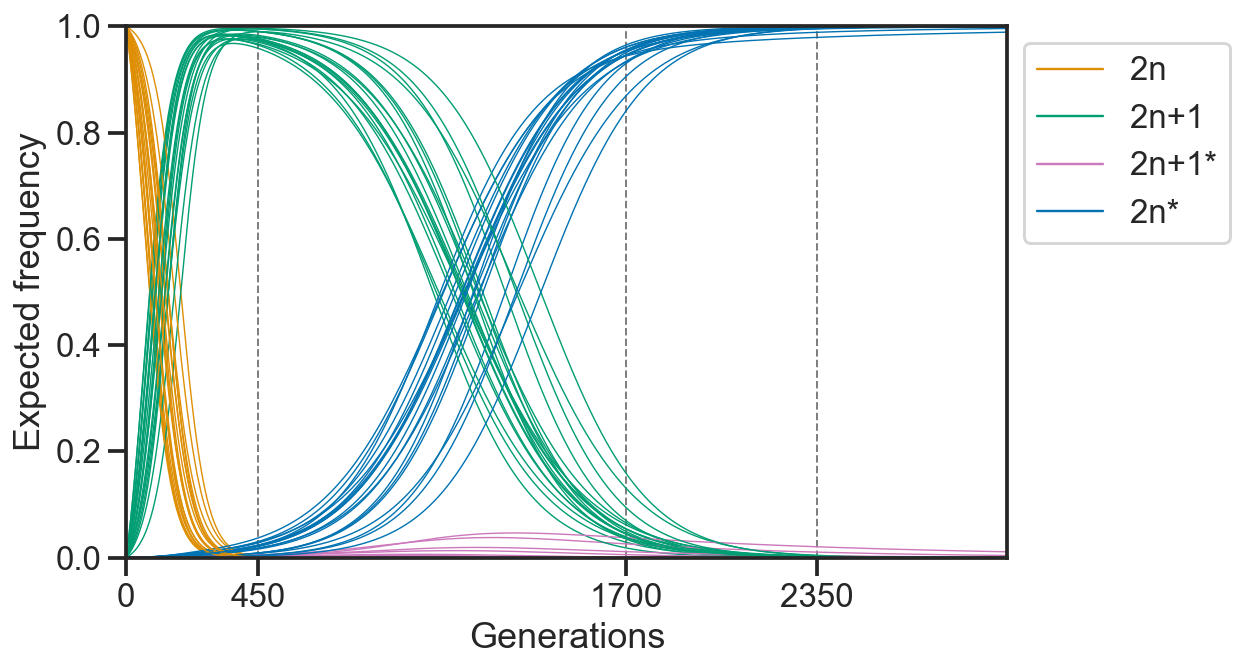

In [128]:
import seaborn as sns
sns.set(style="ticks",context='talk' ,rc={"lines.linewidth": 2.5, 'lines.markersize': 7})
blue,yellow,green,red,pink,brown,pink2,grey = sns.color_palette("colorblind", 8)

def plot_progress(progresses, state_names=['2n','2n+1','2n+1*','2n*'], colors=[yellow,green,pink,blue]):
    fig, ax = plt.subplots(figsize=(9, 5))

    #nparr[:,stateid][:,replicaid]

#     plt.fill_between([450, 1700], [0,0], [1,1] , alpha=0.2, color=red)
#     plt.fill_between([1701, 2350], [0,0], [1,1] , alpha=0.2, color=blue)
    plt.axvline(450,linestyle='--',linewidth=1, color='grey')
    plt.axvline(1700,linestyle='--',linewidth=1, color='grey')
    plt.axvline(2350,linestyle='--',linewidth=1, color='grey')

    first = True
    for p in progresses:
        ind = -1
        for n,c in zip(state_names, colors):
            ind+=1
            if first==True:
                plt.plot(range(min(len(p[0]),3000)), p[ind], label=n, color=c,linewidth=0.7)
            else:
                plt.plot(range(min(len(p[0]),3000)), p[ind], color=c, linewidth=0.7)
        first=False

    plt.xlabel('Generations')
    plt.ylabel('Expected frequency')
    
#     plt.xlim(10**-0.2,3000)
#     plt.ylim(10**-5,10**0.2)
#     plt.xscale('log')
#     plt.yscale('log')
    leg = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    for line in leg.get_lines():
        line.set_linewidth(1.2)
        
    plt.xlim(0,3000)
    plt.ylim(0,1)
    ax.set_xticks([0,450,1700,2350])
    
plot_progress(progresses_mean[:20])
plt.tight_layout()
plt.gcf().savefig(f'{output_path}/dynamics.pdf', bbox_inches='tight', dpi=100)